In [115]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import seaborn
from BendCurve import *

In [157]:
# For now, diameters are assumed to decrease linearly
def computeDiameters(maxDiameter, sVals):
    diameters = maxDiameter * (sVals[-1] - sVals[:]) / sVals[-1]
    return diameters

# Returns normalized approximations of tangents to the curve at all curvePoints
def computeTangents(curvePnts, nodes):
    # First and last tangents can be computed exactly
    tangents = np.zeros((curvePnts.shape[0], 2))
    tangents[0,:] = nodes[1,:] - nodes[0,:]
    tangents[-1,:] = nodes[-1,:] - nodes[-2,:]
    # All other tangents are approximated using vectors between neighborings points
    vectors = np.array([curvePnts[i+1] - curvePnts[i] for i in range(curvePnts.shape[0]-1)])
    tangents[1:-1,:] = [(vectors[i] + vectors[i+1]) / 2 for i in range(vectors.shape[0]-1)]
    # Normalize tangents
    tangents[:,:] = [t / np.linalg.norm(t) for t in tangents]
    return tangents

# Returns normalized approximations of normals to the curve in the specified 
# direction (cw or ccw) at all curvePoints
def computeNormals(curvePnts, nodes, direction):
    # Tangents to the curve
    tangents = computeTangents(curvePnts, nodes)
    # Normals to the curve
    normals = np.array([direction * np.array([-t[1], t[0]]) for t in tangents])
    return normals

# Returns the center of the coil at all curvePoints
def computeCenters(curvePnts, diameters, normals):
    centers = np.array([curvePnts[i] + diameters[i] * normals[i] / 2 for i in range(curvePnts.shape[0])])
    return centers

# Returns the offset curve as a list of points
# Each offset point is computed as a curve point + normal * diameter
def computeOffsetPoints(curvePnts, diameters, normals):
    offsetPnts = np.array([curvePnts[i] + diameters[i] * normals[i] for i in range(curvePnts.shape[0])])
    return offsetPnts

# Returns a matplotlib.path object whose vertices are curvePnts and offsetPnts.
# Starts at the endpoint of the curve, traverses the curve in reverse order, jumps
# to the offset curve at the curve's initial point, and then traverses the offset
# curve in forwards order; Therefore the path is guaranteed to be closed.
def getCoilPath(curvePnts, offsetPnts):
    vertices = np.zeros((curvePnts.shape[0] + offsetPnts.shape[0], 2))
    vertices[0:curvePnts.shape[0]] = np.flip(curvePnts, 0)[:] # Reversed so that path starts and ends at endpoint
    vertices[curvePnts.shape[0]:vertices.shape[0]] = offsetPnts[:]
    return Path(vertices, closed=True)

# Test for point membership of the pegs in the coil path.
# Returns a numpy array of all pegs inside the offset region.
# NOTE: This method sometimes misses boundary points. Consider thresholding.
def getCandidatePegs(pegs, coilPath):
    candidatePegs = pegs[np.where(coilPath.contains_points(pegs))]
    return candidatePegs

# First, narrow down the list of pegs to only those in the coil's path.
# Next, step through the coil's motion. At each point, compute the distance between the
#   coil's center and the pegs. If any peg's distance is less than the coil's radius,
#   a collision has occured; return the current peg and the previous s-value.
#   (If collision detected on first iteration, return current s-value.)
# Why previous s-value? Because intuitively that was the last point on the curve
#   to successfully be placed. This is where the edit should be anchored.
# NOTE: Possible future improvement
#   1) Find s-value to specific degree of accuracy, rather than limiting the result
#      to a predetermined list (sVals).
#   2) Does not currently check if more than one peg collides at the same s-value.
def findCollisionPoint(pegs, coilPath, centers, diameters):
    
    # Only consider pegs that the coil could actually touch
    candidatePegs = getCandidatePegs(pegs, coilPath)
    
    # Traverse through the coil's path
    for i in range(centers.shape[0]):
        center = centers[i]
        radius = diameters[i] / 2
        # Check each peg
        for peg in candidatePegs:
            # Compute center and distance to peg to determine if peg is inside coil
            dist = sqrt((peg[0] - center[0])**2 + (peg[1] - center[1])**2)
            if dist < radius:
                # Collision detected
                return peg, max(i-1, 0)
    
    # If no collision detected, return None
    return None, None
    
# Finds all possible coil-peg collisions with the current intended path.
# If more than one collision is found, the first collision to occur is selected.
# If no collision is detected, returns None.
# Parameters:
# ...
# Returns:
#     peg = Coordinates of peg if collision is found; None if no collision
#     t0 = t-value on curve where coil most recently 'placed' the path; None if no collision
def detectCollision(pegs, curve, direction, maxDiameter, sVals, animate):
    
    # Start pre-computations... (I might gather these into one function to reduce clutter)
    # Points on the curve
    curvePnts = curve.evaluate_multi(sVals).transpose()
    # Control points
    nodes = curve.nodes.transpose()
    
    # Diameter of coil at all s-values
    diameters = computeDiameters(maxDiameter, sVals)
    # Normals to the curve at all s-values
    normals = computeNormals(curvePnts, nodes, direction)
    # Center of the coil at all s-values
    centers = computeCenters(curvePnts, diameters, normals)
    
    # Construct an offset curve where the amount of offset at any
    # point on the curve is the radius of the coil.
    offsetPnts = computeOffsetPoints(curvePnts, diameters, normals)
    
    # Represent the coil path as a matplotlib.path object whose 
    # vertices are the curvePnts and offsetPnts
    coilPath = getCoilPath(curvePnts, offsetPnts)
    
    # ... end pre-computations
    
    # Output the peg with which the coil will collide,
    # and the index at which the collision was detected.
    # If no collision detected, output None and None
    peg, i = findCollisionPoint(pegs, coilPath, centers, diameters)
    
    # If animation is desired:
    # Plot coil path, intended curve, pegs, and collision
    if animate:
        seaborn.set()
        ax = plt.gca()
        #plotCoilPath(coilPath, ax, edgeColor='blue', faceColor='gray')
        plotBezierCurve(curve, ax, color='purple')
        plotPegs(pegs, ax)
        if peg is not None:
            plotCircle(centers[i], diameters[i], ax, color='purple')
            ax.plot(peg[0], peg[1], marker='o', color='gold')
            ax.plot(curvePnts[i,0], curvePnts[i,1], marker='o', color='purple')
        ax.axis('equal')
        plt.title('Detect collision')
        plt.show()
    
    # Return all info needed to handle the collsion
    if peg is None:
        return None
    else:
        return (sVals[i], curvePnts[i], peg, diameters[i], centers[i])

In [141]:
#
def handleCollision():
    
    left = None
    arc = None
    right = None
    
    return left, arc, right

In [150]:
#
def predictPath(pegs, curve, direction, maxDiameter, numPts=100, animate=False):
    
    # Plot initial curve and pegs if desired
    if animate:
        seaborn.set()
        ax = plt.gca()
        plotPegs(pegs, ax)
        plotBezierCurve(curve, ax, color='purple')
        ax.axis('equal')
        plt.title('Initial path')
        plt.show()
    
    # These will store output
    beziers = []
    arcs = []
    
    # Set up parameters to step through the curve
    sVals = np.linspace(0, 1, num=numPts, endpoint=True)
    currSVals = sVals
    currCurve = curve

    # Loop will continue to execute until no collisions are detected
    while True:
    
        # Detect collision
        results = detectCollision(pegs, curve, direction, maxDiameter, currSVals, animate)
        
        # No collisions ==> add curve and exit loop
        if results is None:
            beziers.append(currCurve)
            break
        else:
            # Unpack the results tuple and pass the contents to handleCollision
            (s0, curvePnt, peg, diam, center) = results
            left, arc, currCurve = handleCollision(s0, curvePnt, peg, diam, center)
            # Adjust the lists appropriately
            beziers.append(left)
            if arc is not None:
                arcs.append(arc)
            # Adjust sVals for recursion
        
        break
        
    return beziers, arcs

In [152]:
def plotPegs(pegs, ax, color='black'):
    ax.plot(pegs[:,0], pegs[:,1], marker='o', linestyle='None', color=color)
    
def plotPredictedPath(beziers, arcs, ax,
        bezierColor='black', bezierControlColor='gray',
        bezierShowControlPoints=False, bezierControlPointMarker='.',
        bezierShowControlPolygon=False, bezierControlPolygonStyle='-',
        arcColor='black', arcLinestyle='-', arcShowCenter=False,
        arcCenterColor='black', arcCenterMarker='.',
        pegs=np.array([]), pegsColor='black'):
    
    # Plot beziers
    for bezier in beziers:
        plotBezierCurve(bezier, ax, color=bezierColor,
            controlColor=bezierControlColor,
            showControlPoints=bezierShowControlPoints,
            controlPointMarker=bezierControlPointMarker,
            showControlPolygon=bezierShowControlPolygon,
            controlPolygonStyle=bezierControlPolygonStyle)
    
    # Plot arcs
    for arc in arcs:
        plotArc(arc, ax, color=arcColor,
               linestyle=arcLineStyle,
               showCenter=arcShowCenter,
               centerColor=arcCenterColor,
               centerMarker=arcCenterMarker)
    
    # Plot pegs
    if pegs.size > 1:
        plotPegs(pegs, ax, color=pegsColor)

def plotCoilPath(coilPath, ax, edgeColor='black', faceColor='gray'):
    patch = patches.PathPatch(coilPath, ec=edgeColor, fc=faceColor)
    ax.add_patch(patch)

def plotCircle(center, diameter, ax, color='black'):
    circle = patches.Arc(center, diameter, diameter, color=color)
    ax.add_patch(circle)

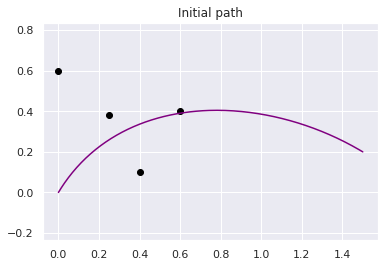

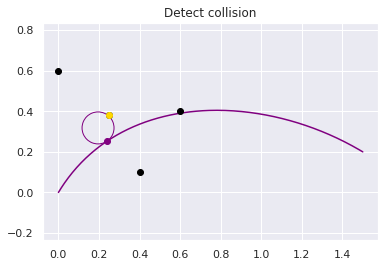

In [158]:
def main():
    
    # Declare parameters
    # Pegs are (x,y) coordinates
    pegs = np.array([
        [0.25, 0.38],
        [0.4, 0.1],
        [0.6, 0.4],
        [0.0, 0.6]
    ])
    # Nodes are (x,y) coordinates for control points for a bezier curve
    nodes = np.array([
        [0.0, 0.0],
        [0.3, 0.5],
        [1.0, 0.5],
        [1.5, 0.2]
    ])
    # Direction indicates on which side of the curve the coil is located
    # +1 for left, -1 for right
    direction = 1
    # Initial diameter of the coil
    maxDiameter = 0.2
    
    curve = bezier.Curve.from_nodes(nodes.transpose())
    
    # Call the method to predict the path of the unrolled wire
    # Returns lists of bezier curves and arcs
    beziers, arcs = predictPath(pegs, curve, direction, maxDiameter, animate=True)
    
    # Plot the predicted path
    #ax = plt.gca()
    #plotPredictedPath(beziers, arcs, ax, pegs=pegs, bezierColor='blue', arcColor='green')
    #ax.axis('equal')
    #plt.show()
    
    
    

if __name__ == '__main__':
    main()